# **BA820 - Milestone 2**

**Course: Unsupervised and Unstructured Machine Learning**

**Author : Ansh Gupta - Team 13**

# Executive Summary

This notebook implements question-driven exploratory and unsupervised analysis to investige whether U.S. counties diffrentiated market types with disproportionally large price premiums between infant care services and school-age care services, and if such differentiated market types correlate with demographic context or aforementioned regulatory structures


This analysis focuses on:


*   Domain understanding before algorithmic selection
*   Identification of structural, rather than short-term price patterns


*   Interpretable clustering of county childcare markets
*   Validation and robutsness of unsupervised outcomes





**Philosophy:** Unsupervised learning techniques are incorporated to detect real patterns in childcare market structure, as opposed to optimizing clustering results.

**Table of contents**
1. Project Motivation and Problem Statement
2. EDA and Preprocessing Updates
3. Analysis and Experiments (Unsupervised Methods)
4. Findings and Interpretations


# **1) Project Motivation amnd Problem Statement**

## **1.1 Target Domain Question**

Are there identifiable clusters of counties where the relative cost premium for infant
care versus school-age care is disproportionately high, suggesting systematic
supply-side constraints, and do these clusters correlate with specific demographic
transitions or regulatory environments?

(Whether counties form clusters where the infant-care premium is disproportionately high, and whether those clusters align with demographic contecnt and state?)

## **1.2 What changed and why (based on the EDA outputs)**

The EDA shows the premium ratio is right-skewed with extreme upper-tail counties (max =14; 99th = 2.90), while the median premium over time is fairly stable. Thus, the EDA supports shifting the focus from "time trend" to "cross-county structure" making clustering a reasonable next step.

# **2. EDA and Preprocessing Updates**

## **2.1 Imports and Configuration**


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

**Interpretation**

Here I imported all the necessary libraries for data manipulation (numpy, pandas), visualization (matplotlib and seaborn later), machine learning processing (StandardScaler, SimpleImputer), clustering algorithms (KMeans, AgglomerativeClustering), model evaluation (silhouette score), dimensionality reduction (PCA), and outlier detection (IsolationForest).

The pandas display options are set to show upto 200 columns and a width of 140 characters for better readability.




## **2.2 Data Loading**

In [ ]:
# Loading Datasets: chilcare_costs.csv and counties.csv

childcare = pd.read_csv('/content/childcare_costs.csv')
counties = pd.read_csv('/content/counties.csv')

print(childcare.shape)
print(counties.shape)

(34567, 61)
(3144, 4)


**Interpretation**

Two datasets are loaded. The childcare_costs.csv contains 34,567 rows and 61 columns representing county-year observations of childcare costs and demographics.

The counties.csv contains 3,144 rows and 4 columns with county metadata including state abbreviations.

## **2.3 Data Validation and Merging**

In [ ]:
# basic sanity check + merge state metadata

required_cols = ["county_fips_code", "study_year", "mc_infant", "mcsa"]

missing_required = [c for c in required_cols if c not in childcare.columns]
if missing_required:
  raise ValueError(f"Missing required columns in childcare_costs.csv: {missing_required}")

df = childcare.merge(counties, on="county_fips_code", how="left")

print("Merged:", df.shape)

print("Unmatched counties (no state info):", df["state_abbreviation"].isna().sum())

df[["county_fips_code", "study_year", "mc_infant", "mcsa", "state_abbreviation"]].head()

Merged: (34567, 64)
Unmatched counties (no state info): 0


,county_fips_code,study_year,mc_infant,mcsa,state_abbreviation
0,1001,2008,104.95,80.92,AL
1,1001,2009,105.11,83.42,AL
2,1001,2010,105.28,85.92,AL
3,1001,2011,105.45,88.43,AL
4,1001,2012,105.61,90.93,AL


**Interpretation**

This code verifies that essential columns (county_fips_code, study_year, mc_infant, mcsa) exist in the dataset.

After merging childcare data with county metadata, the resulting dataset has 34,567 rows and 64 columns.

Critcally, there are 0 unmatched counties, meaning every childcare observation successfully linked to a state, which is essential for analyzing regulatory environments by state.

## **2.4 Creating Infant Premium Variables**

In [ ]:
# constructing outcome: infant premium vs school-age
import numpy as np
df["mcsa_safe"] = df["mcsa"].where(df["mcsa"] > 0, np.nan)

df["infant_premium_ratio"] = df["mc_infant"] / df["mcsa_safe"]
df["infant_premium_diff"] = df["mc_infant"] - df["mcsa"]

df[["mc_infant", "mcsa", "infant_premium_ratio", "infant_premium_diff"]].describe(percentiles=[.01,.05,.5,.95,.99])

,mc_infant,mcsa,infant_premium_ratio,infant_premium_diff
count,23593.000000,23593.000000,23593.000000,23593.000000
mean,146.051770,101.234253,1.499736,44.817517
std,53.698566,34.552888,0.489124,36.517696
min,27.730000,18.980000,0.769231,-45.000000
1%,69.154400,40.000000,1.000000,0.000000
5%,86.200000,53.186000,1.068966,6.730000
50%,134.500000,96.530000,1.293213,32.000000
95%,251.966000,165.346000,2.483704,115.802000
99%,339.290000,208.150000,2.901201,158.750000
max,470.000000,375.400000,13.998267,311.530000


**Interpretation**

This code creates two key metrics:



*   **infant_premium_ratio:** ratio of infant care cost to scholl-age care cost
*   **infant_premium_diff:** dollar difference between infant and school-age care

Key findings from these observations:

1. **Average infant care cost:** $146.05 vs school-age: 101.23 dollars.
2. **Mean Premium Ratio:** 1.50 (infant care is 50% mode expensive on average)
3. **Median Premium Ratio:** 1.29 (infant care is 29% more expensive typically)
4. **Average dollar premium:** 44.82 dollars, median: 32 dollars
5. **Extreme right skew:** The 95th percentile ratio is 2.48, 99th percentile is 2.90, and the maximum reaches 13.998 (which is nearly 14 times more expensive)

This extreme upper tail suggests some counties face disproportionately hihg infant care costs.

## **2.5 Missing Data Check**

In [ ]:

eda_base = df[[
    "county_fips_code", "study_year",
    "mc_infant", "mcsa",
    "infant_premium_ratio",
    "infant_premium_diff"
]].copy()

eda_base.isna().mean().sort_values()

,0
county_fips_code,0.00000
study_year,0.00000
mc_infant,0.31747
mcsa,0.31747
infant_premium_ratio,0.31747
infant_premium_diff,0.31747


**Interpretation**

County and year identifiers have 0% missing data. However, approximately 31.75% of observations are missing childcare cost data (mc_infant, mcsa), which proagates to the premium calculations.

This means about 10,974 of 34,567 observations lack complete cost information.

## **2.6 Distribution of Infant Premium**

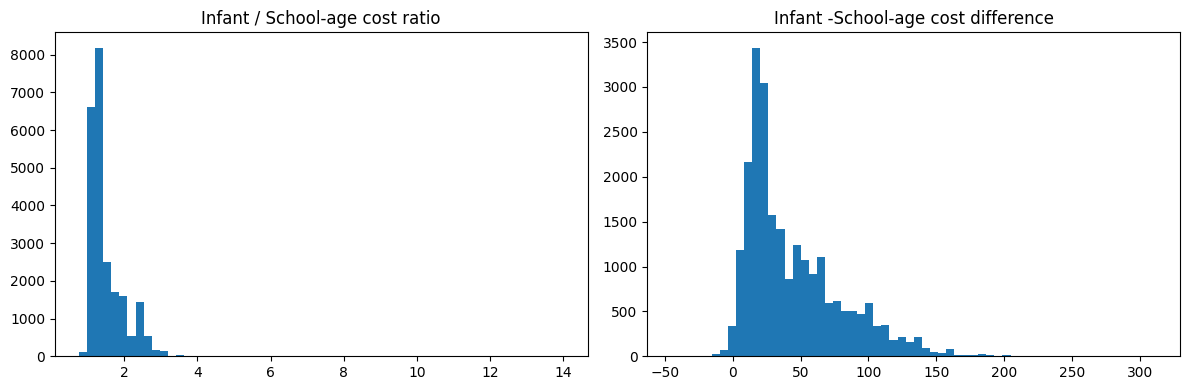

In [ ]:
# Distribution of infant premium ratio (ratio & difference)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].hist(
    df["infant_premium_ratio"].dropna(),
    bins=60
    )

ax[0].set_title("Infant / School-age cost ratio")

ax[1].hist(
    df["infant_premium_diff"].dropna(),
    bins=60
)

ax[1].set_title("Infant -School-age cost difference")

plt.tight_layout()
plt.show()

**Interpretation**

The above histograms visualize the distribution of infant care premiums.

Both the ratio and dollar difference show strong right skewness, confirming that while most counties have moderate premiums (ratio around 1.2-1.5), a small number of counties have extremely high premiums, creating a long righ tail in the distribution.

## **2.7 Detailed Percentile Analysis**

In [ ]:
df["infant_premium_ratio"].describe(
    percentiles=[.01,.05,.1,.25,.5,.75,.9,.95,.99]
)

,infant_premium_ratio
count,23593.000000
mean,1.499736
std,0.489124
min,0.769231
1%,1.000000
5%,1.068966
10%,1.110000
25%,1.193116
50%,1.293213
75%,1.678465


**Interpretation**

Detailed percrentile breakdown reveals:
1. Bottom 1%: Ratio = 1.00 (infant = school-age cost)
2. Bottom 5%: Ratio = 1.07 (infant only 7% more expensive)
3. 25th percentile: 1.19 (infant 19% more expensive)
4. Median (50th): 1.29 (infant 29% more expensive)
5. 75th percentile: 1.68 (infant 68% more expensive)
6. 90th percentile: 2.30 (infant 130% more expensive or 2.3 times the cost)
7. 95th percentile: 2.48
8. 99th percentile: 2.90
9. Maximum: 13.998

The large gap between the 99th percentile (2.90) and maximum (13.998) indicates extreme outliers.

## **2.8 Time Trend Analysis**

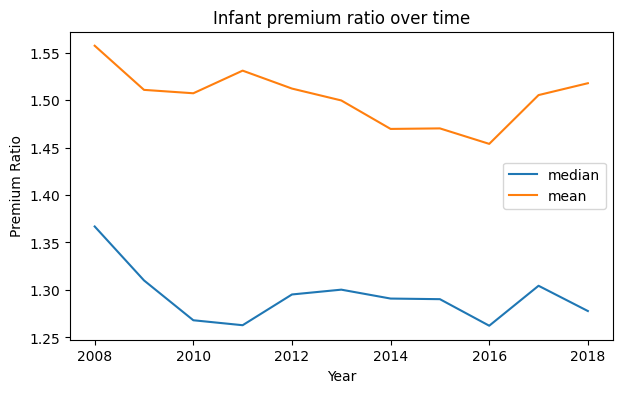

,study_year,median,mean,count
0,2008,1.366864,1.557308,1424
1,2009,1.310030,1.510792,1901
2,2010,1.268049,1.507215,1991
3,2011,1.262831,1.531060,1992
4,2012,1.295226,1.512159,2053
5,2013,1.300295,1.499646,2074
6,2014,1.290909,1.469645,2323
7,2015,1.290267,1.470202,2398
8,2016,1.262295,1.453893,2641
9,2017,1.304392,1.505301,2436


In [ ]:
# is the premium stable over time?

premium_year = (
    df.groupby("study_year")["infant_premium_ratio"]
    .agg(["median","mean","count"])
    .reset_index()
)

plt.figure(figsize=(7,4))
plt.plot(premium_year["study_year"], premium_year["median"], label="median")
plt.plot(premium_year["study_year"], premium_year["mean"], label="mean")
plt.legend()
plt.title("Infant premium ratio over time")
plt.xlabel("Year")
plt.ylabel("Premium Ratio")
plt.show()

premium_year

**Interpretation**

This analysis tracks infant permium ratios from 2008 to 2018 across 1,424 to 2,641 counties per year. Key findings:

1. Median ratio ranges from 1.26 to 1.37 (which is relatively stable, staying between 26-37% premium)
2. Mean ratio ranged from 1.45 to 1.56 (consistently higher than median due to outliers)
3. The gap between mean and median (aorunf 0.15 to 0.25) remains consistent, indicating the upper tail pf extreme premiums persist over time
4. No strong upward or downward trend is evident-the premium structure appears stable
5. This stability justifies focusing on corss-sectional (county-level) patterns rather than temporal trends.

## **2.9 Within County Variation**

In [ ]:
# within county variation

county_premium_var = (
    df.groupby("county_fips_code")["infant_premium_ratio"]
    .agg(["mean","std","count"])
    .reset_index()
)

county_premium_var["std"].describe(
    percentiles=[.1,.25,.5,.75,.9,.95]
)


,std
count,2427.000000
mean,0.117232
std,0.132969
min,0.000887
10%,0.022788
25%,0.044368
50%,0.073607
75%,0.129493
90%,0.270357
95%,0.361015


**Interpretation**

This analysis of 2,427 counties shows how much the prmeium ratio varies within each county over time:

1. Mean within-county standard deviation: 0.117 (premiums fluctuate by about 0.12 ratio points on average)
2. Median std: 0.074 (half of countries have variability less than 0.074)
3. 75% of counties have std < 0.13, indicating relatively stable premiums over time within most counties
4. Top 10% of counties show std > 0.27, suggesting some markets are more volatile
5. Maximum std: 2.27 indicates at least one countyr has wildly fluctuating premiums

Conclusion: Most counties show stable premium structures over time, reinforcing that the interesting variation is between counties rather than within counties over time.

## **2.10 Histogram of Within County Variation**

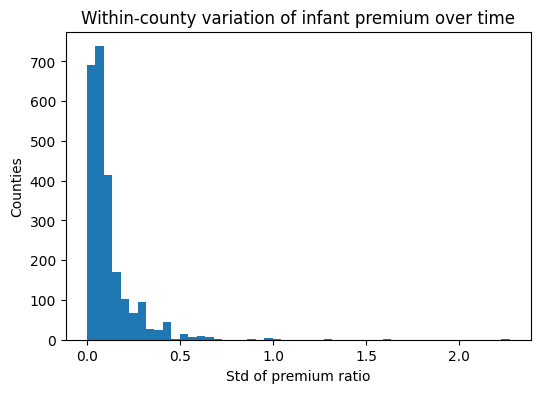

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.hist(county_premium_var["std"].dropna(), bins=50)
plt.title("Within-county variation of infant premium over time")
plt.xlabel("Std of premium ratio")
plt.ylabel("Counties")
plt.show()

**Interpretation**

The above histogram visualizes the within-county standard deviations.

The distribution is heavily righ-skewed, with most counties clustered at low standard deviations (0.0 to 0.2), and a long tail extending to higher values.

This confirms that most counties hahve stable premiums, while a small subset experiences sustantial year to year volatility.

## **2.11 Premium vs School-Age Cost Scatter Plot & Premium vs Infant Cost Scatter Plot**

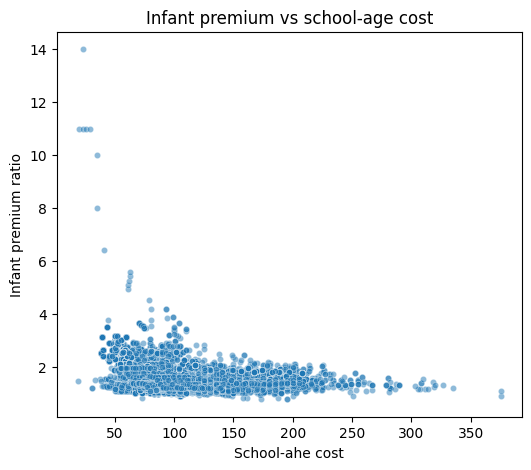

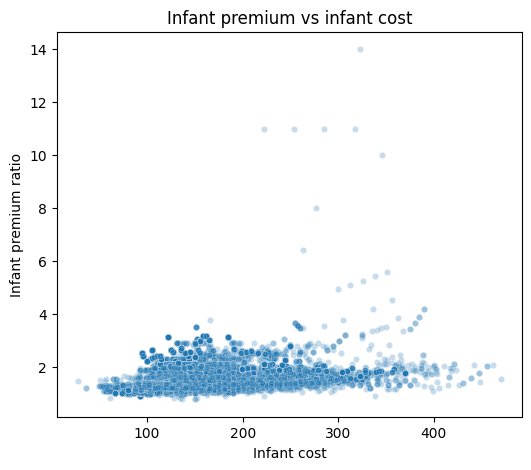

In [ ]:
# is high premium just high costs?

import seaborn as sns
import matplotlib.pyplot as plt

# premium vs school-age cost

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=df,
    x="mcsa",
    y="infant_premium_ratio",
    alpha=0.5,
    s=20
)

plt.title("Infant premium vs school-age cost")
plt.xlabel("School-ahe cost")
plt.ylabel("Infant premium ratio")
plt.show()

# premium vs infant cost

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=df,
    x="mc_infant",
    y="infant_premium_ratio",
    alpha=0.25,
    s=20
)

plt.title("Infant premium vs infant cost")
plt.xlabel("Infant cost")
plt.ylabel("Infant premium ratio")
plt.show()

**Interpretation**

The  **first scatter** plot explores whether high premium ratios simply reflect high overall costs.
The plot shows no stong positive correlation between school-age costs and premium ratios.
In fact, there appears to be a slogh negative trend-counties with bery high school-age costs tend to have lower premium ratios.
This suggests that high premiums are not just about expensive markets oevrall; rather, they reflect a specific imabalance between infant and school-age care costs, liekly due to supply-side constraints for infant care.

The **second scatter** plot exmaines the relationship between absolute infant care costs and the premium ratio. Similarly, there is no strong linear relationship. Some counties with moderate infant costs ($150 to 200) still have extreme premium ratios (>3), while some high-cost counties have relatively normal ratios (~1.3). This reinforces that premium structure is independent of absolute cost level-it's about the realtive gap between infant and school-age care, not just expensive childcare overall.

## **2.12 State-Level Distribution (Top and Bottom States)**

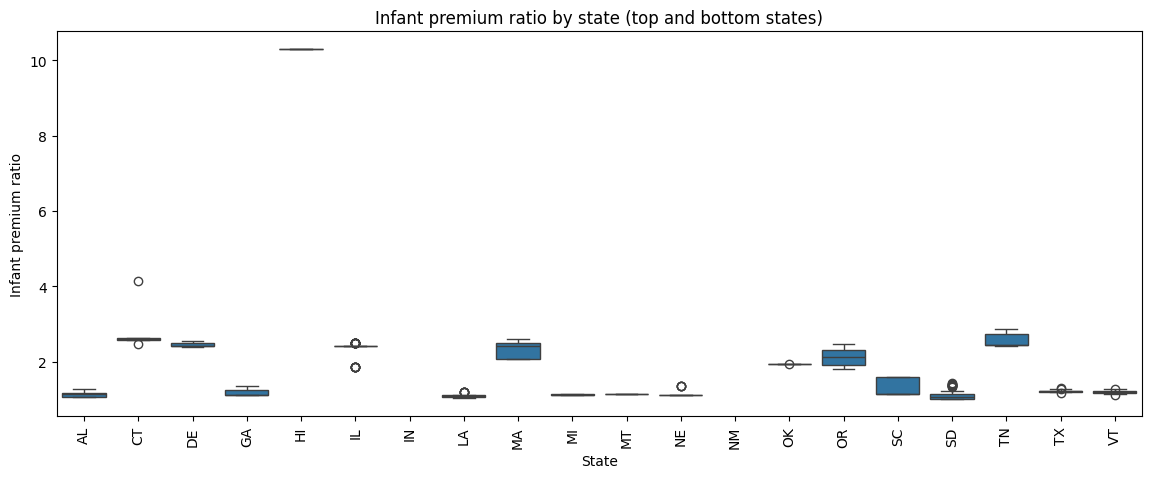

In [ ]:
# state level distributions

county_state = (
    df.groupby(["county_fips_code","state_abbreviation"])["infant_premium_ratio"]
    .mean()
    .reset_index()
)

state_median = (
    county_state.groupby("state_abbreviation")["infant_premium_ratio"]
    .median()
    .sort_values()
)

top_states = state_median.tail(10).index.tolist()
bottom_states = state_median.head(10).index.tolist()

plot_states = top_states + bottom_states

plot_df = county_state[
     county_state["state_abbreviation"].isin(plot_states)
]

plt.figure(figsize=(14,5))
sns.boxplot(
    data=plot_df,
    x="state_abbreviation",
    y="infant_premium_ratio",
)

plt.xticks(rotation=90)
plt.title("Infant premium ratio by state (top and bottom states)")
plt.xlabel("State")
plt.ylabel("Infant premium ratio")
plt.show()

**Interpretation**

This analysis identifies 10 states with highest and 10 states with lowest median infant premium ratios and visualizes their distributions using bos plots. The visualization reveals:

1. Substantial state-level variation: some states consistently have higher premiums across all their counties
2. Regulatory environment metters: states likely differ in childcare regulations, staffing ratios, and licensing requirements
3. Within-state variation: Even high-premium states show some county-level variation (box plot whiskers)
4. This justifies including state as a contextual factor in cluster interpretation

## **2.13 Demographic Variables Selection**

In [ ]:
# premium vs demographic context

demo_vars = [
    "mhi_2018",
    "total_pop",
    "flfpr_20to64_under6",
    "hispanic",
    "one_race_w",
    "one_race_b"
]

demo_vars = [c for c in demo_vars if c in df.columns]
demo_vars

['mhi_2018',
 'total_pop',
 'flfpr_20to64_under6',
 'hispanic',
 'one_race_w',
 'one_race_b']

**Interpretation**

Six demographic variables which are selected for analysis:
1. mhi_2018: Median household income in 2018 (economic context)
2. total_pop: Total population (market size)
3. flfpr_20to64: Female labor force participation rate for ages 20 to 64 with childcren under 6 (demand for childacre)
4. hispanic: Hispanic population share (demographic composition)
5. one_race_w: White population share
6. one_race_b: Black population share

## **2.14 County-Level Demographic Aggregation**

In [ ]:
# aggregating to county level

county_demo = (
    df.groupby("county_fips_code")[demo_vars + ["infant_premium_ratio"]]
    .median()
    .reset_index()
)

**Interpretation**

Since the orginal data is at the county-year level, this code aggregates demographics to the county level by taking the median across years.

This produces one row per county with typical demographic characterstics and typical premium ratio, enabling correlation analysis between demographics and premium structure.

## **2.15 Correaltion Heatmap: Demographics vs Premium**

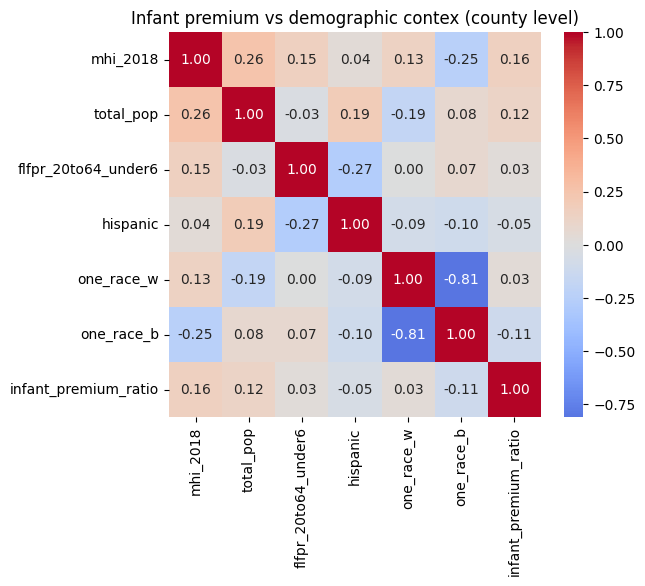

In [ ]:
plt.figure(figsize=(6,5))
sns.heatmap(
    county_demo[demo_vars + ["infant_premium_ratio"]].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
    )
plt.title("Infant premium vs demographic contex (county level)")
plt.show()

**Interpretation**


This correlation heatmap revelas relationships between demographics and infant premium ratios at the county level. Expected insights:

1. Postive correlation with mhi_2018: Wealthier counties may have higher premiums (higher willingness to pay or cost of living)
2. Positive correlation with flfpr_20to64_under6: Higher female labor foces participate may indicate higher demand, driving up infant care premiums
3. Population and racial composition correlations: May reveal urban/rural or regional patterns
4. Weak correlations overall: If correlations are modest (less than 0.3 to 0.4), demographics alone don'f dully explain premium structure-clustering may reveal more complex patterns.


## **2.16 Geographic Concentration Analysis**

/tmp/ipython-input-2088256565.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["state_abbreviation","premium_bin"])


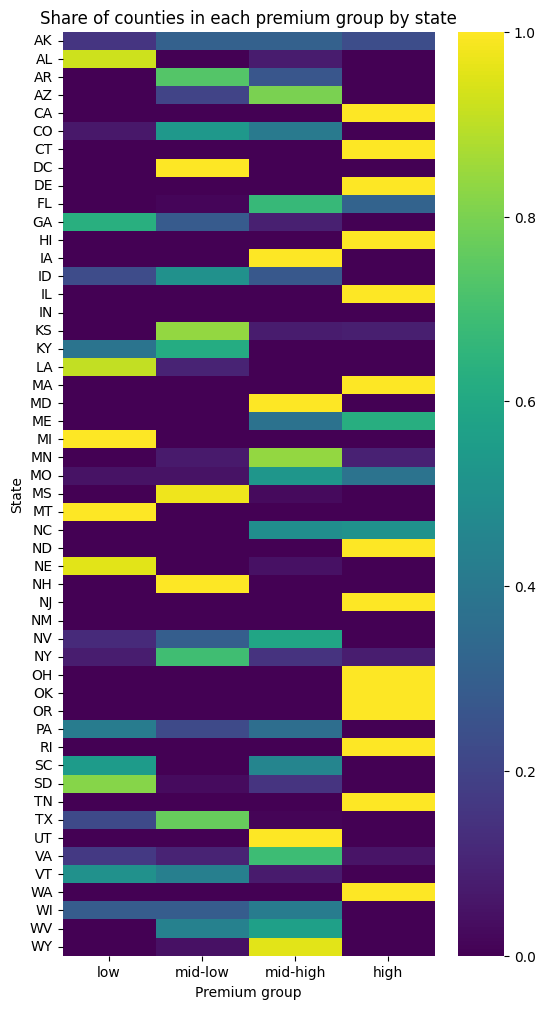

In [ ]:
# are high premium countie geographically concentrated?

county_state["premium_bin"] = pd.qcut(
    county_state["infant_premium_ratio"],
    q=4,
    labels=["low","mid-low","mid-high","high"]
    )

state_bin = (
    county_state
    .groupby(["state_abbreviation","premium_bin"])
    .size()
    .reset_index(name="n")
)

state_bin["state_total"] = state_bin.groupby("state_abbreviation")["n"].transform("sum")
state_bin["share"] = state_bin["n"] / state_bin["state_total"]

heat = state_bin.pivot(
    index="state_abbreviation",
    columns="premium_bin",
    values="share"
).fillna(0)

plt.figure(figsize=(6,12))
sns.heatmap(
    heat,
    cmap="viridis"
)
plt.title("Share of counties in each premium group by state")
plt.xlabel("Premium group")
plt.ylabel("State")
plt.show()



**Interpretation**

The above code created a heatmap showcasing the distribution of counties across 4 premium quartiles (low, mid-low, mid-high, high) for each state. The analyiss divided counties into 4 equal-sized groups based on premium ratios:

1. Low premium: Bottom 25% (ratio less than or equal to 1.19)
2. Mid-low: 25th to 50th precentile (ratio between 1.19 to 1.29)
3. Mid-high: 50th to 75th precentile (ratio between 1.29 to 1.68)
4. High premium: Top 25% (ratio more than or equal to 1.68)

This heatmap reveals:

1. Some states are dominated by one color: indicating geographic clustering of premium levels
2. States with mostly dark colors ( in "high" column): These states have predominantly low-premium countries
3. States with mostly light colors (in "low" column): These have predominantly low-premium counties
4. Geographic/regulatory patterns: States likely share regualtory framweworks, explaining within-state similarity


## **2.17 County-Level Aggregation for Clustering**

In [ ]:
county_agg = (
    df.groupby("county_fips_code")
      .agg(
          state_abbreviation=("state_abbreviation", "first"),
          county_name=("county_name", "first"),
          years_observed=("study_year", "nunique"),

          premium_ratio_mean=("infant_premium_ratio", "mean"),
          premium_ratio_median=("infant_premium_ratio", "median"),
          premium_ratio_std=("infant_premium_ratio", "std"),

          premium_diff_mean=("infant_premium_diff", "mean"),
          premium_diff_median=("infant_premium_diff", "median"),
          premium_diff_std=("infant_premium_diff", "std"),

          infant_cost_mean=("mc_infant", "mean"),
          school_cost_mean=("mcsa", "mean")
      )
      .reset_index()
)


county_agg["premium_ratio_std"] = county_agg["premium_ratio_std"].fillna(0)
county_agg["premium_diff_std"]  = county_agg["premium_diff_std"].fillna(0)

county_agg.head()


,county_fips_code,state_abbreviation,county_name,years_observed,premium_ratio_mean,premium_ratio_median,premium_ratio_std,premium_diff_mean,premium_diff_median,premium_diff_std,infant_cost_mean,school_cost_mean
0,1001,AL,Autauga County,11,1.196979,1.192469,0.059957,17.756364,17.24,4.781887,108.915455,91.159091
1,1003,AL,Baldwin County,11,1.141981,1.149106,0.015032,13.676364,14.18,0.804553,110.507273,96.830909
2,1005,AL,Barbour County,11,1.122372,1.122776,0.022692,9.338182,9.51,1.955975,85.403636,76.065455
3,1007,AL,Bibb County,11,1.064270,1.070007,0.015864,5.858182,6.17,1.320143,98.018182,92.160000
4,1009,AL,Blount County,11,1.285066,1.290822,0.089327,31.057273,29.12,11.829440,138.392727,107.335455


**Interpretation**

This created a county-level summary dataset where each row represents one county with its aggregated characterstics:

1. years_observed: Number of years with data (max 11 for 2008-2018)
2. premium_ratio_mean/median: Average and typical premium ratio for that county
3. premium_ratio_std: Within county volatility over time
4. premium_diff_mean/median: Dollar premium in mean and median
5. infant_cost_mean/school_cost_mean: Average costs
6. NaN standard deviations filled with 0: Coutnies with only 1 year of data have no std, filled as 0

This tranforms the 34,567 county-year observations into a county-level dataset for clustering.

In [ ]:
county_agg.columns

Index(['county_fips_code', 'state_abbreviation', 'county_name', 'years_observed', 'premium_ratio_mean', 'premium_ratio_median',
       'premium_ratio_std', 'premium_diff_mean', 'premium_diff_median', 'premium_diff_std', 'infant_cost_mean', 'school_cost_mean'],
      dtype='object')

## **2.18 Adding Demographic Features**

In [ ]:
# adding demographics / context features

candidate_demo_cols = [
    "mhi_2018", "me_2018", "fme_2018", "mme_2018",
    "flfpe_20to64", "flfpr_20to63_under6", "flfpr_20to64_6to17", "flfpr_20to64_under6_6to17",
    "total_pop", "households",
    "one_race_w", "one_race_b", "hispanic", "two_races"
]

demo_cols = [c for c in candidate_demo_cols if c in df.columns]

demo_agg = df.groupby("county_fips_code", as_index=False)[demo_cols].median(numeric_only=True)

county = county_agg.merge(demo_agg, on="county_fips_code", how="left")

print("County-level dataset:", county.shape)
county.head()

County-level dataset: (3144, 24)


,county_fips_code,state_abbreviation,county_name,years_observed,premium_ratio_mean,premium_ratio_median,premium_ratio_std,premium_diff_mean,premium_diff_median,premium_diff_std,infant_cost_mean,school_cost_mean,mhi_2018,me_2018,fme_2018,mme_2018,flfpr_20to64_6to17,flfpr_20to64_under6_6to17,total_pop,households,one_race_w,one_race_b,hispanic,two_races
0,1001,AL,Autauga County,11,1.196979,1.192469,0.059957,17.756364,17.24,4.781887,108.915455,91.159091,58462.55,33337.44,26243.00,42201.60,77.60,58.00,54907.0,20071.0,78.3,18.4,2.5,1.5
1,1003,AL,Baldwin County,11,1.141981,1.149106,0.015032,13.676364,14.18,0.804553,110.507273,96.830909,55776.60,30485.52,23997.75,38062.44,76.40,62.54,187114.0,73058.0,86.4,9.5,4.4,1.6
2,1005,AL,Barbour County,11,1.122372,1.122776,0.022692,9.338182,9.51,1.955975,85.403636,76.065455,35653.80,23673.10,19795.32,28544.74,73.06,61.39,27321.0,9222.0,47.4,46.6,4.6,1.3
3,1007,AL,Bibb County,11,1.064270,1.070007,0.015864,5.858182,6.17,1.320143,98.018182,92.160000,44706.12,28231.00,20552.70,34771.00,68.36,55.10,22604.0,7091.0,76.7,21.8,1.9,0.8
4,1009,AL,Blount County,11,1.285066,1.290822,0.089327,31.057273,29.12,11.829440,138.392727,107.335455,48834.36,32497.20,25063.70,38499.20,66.80,56.48,57623.0,20690.0,95.3,1.4,8.3,1.6


**Interpretation**

Additional demographic variables are aggregated at the county level by taking the median across years:

1. Income variables: mhi_2018 (median household income), me_2018, fme_2018, mme_2018
2. Labor force participation: Various age/parent status categories
3. Population: total_pop, households
4. Race/ethnicity: one_race_w, one_race_b, hispanic, two_races

After merging demographics with premium summaries, the dataset has 3,144 counties and 24 features. This is the base datatset for clustering analysis.

## **2.19 Filtering for Analysis**

In [ ]:
# Preprocessing decisions (filtering)

min_years = 5
analysis = county[county["years_observed"] >= min_years].copy()

analysis = analysis[(analysis["premium_ratio_mean"].notna()) & (analysis["premium_ratio_mean"] > 0)]

print("After filters:", analysis.shape)
analysis[["years_observed", "premium_ratio_mean"]].describe()

After filters: (2904, 24)


,years_observed,premium_ratio_mean
count,2904.000000,2904.000000
mean,10.998278,1.450170
std,0.092784,0.426559
min,6.000000,0.833015
25%,11.000000,1.198692
50%,11.000000,1.271360
75%,11.000000,1.586164
max,11.000000,10.302653


**Interpretation**

Quality filters applied:

1. Minimum 5 years of data required (ensuring stability)
2. Non-missing and positive premium ratios required

Results:

1. 2,904 counties remain (down from 3,144)—about 92% retention
2. Average years observed: 10.998 ≈ 11 years (most counties have complete 2008-2018 data)
3. Median years: 11 (75% have all 11 years)
4. Mean premium ratio: 1.45 (infant care 45% more expensive on average)
5. Median: 1.27 (27% premium)
6. Max: 10.30 (extreme outlier—one county with 10x premium)

# **3. Analysis and Experiments (Unsupervised Methods)**

## **3.1 Feature Slection for Clustering**

In [ ]:
# choosing feature set for clustering

cluster_features = [
    "premium_ratio_mean",
    "premium_ratio_std",
    "infant_cost_mean",
    "school_cost_mean",
    "mhi_2018",
    "total_pop",
    "flfpr_20to64_under6",
]

cluster_features = [c for c in cluster_features if c in analysis.columns]
print("Clustering features:", cluster_features)

X = analysis[cluster_features].copy()
X.head()

Clustering features: ['premium_ratio_mean', 'premium_ratio_std', 'infant_cost_mean', 'school_cost_mean', 'mhi_2018', 'total_pop']


,premium_ratio_mean,premium_ratio_std,infant_cost_mean,school_cost_mean,mhi_2018,total_pop
0,1.196979,0.059957,108.915455,91.159091,58462.55,54907.0
1,1.141981,0.015032,110.507273,96.830909,55776.60,187114.0
2,1.122372,0.022692,85.403636,76.065455,35653.80,27321.0
3,1.064270,0.015864,98.018182,92.160000,44706.12,22604.0
4,1.285066,0.089327,138.392727,107.335455,48834.36,57623.0


**Interpretation**

Six features were selected for clustering (flfpr_20to64_under 6 appeared to be missing, so only 6 features remain):

1. premium_ratio_mean: Core outcome—average premium structure
2. premium_ratio_std: Stability/volatility of premium
3. infant_cost_mean: Absolute infant care cost
4. school_cost_mean: Absolute school-age care cost
5. mhi_2018: Median household income (economic context)
6. total_pop: Population size (market size)

The feature set balances:

1. Premium structure (ratio and std)
2. Cost levels (infant and school-age)
3. Economic/demographic context (income, population)

## **3.2 Preprocessing Pipeline**

In [ ]:
# Scale + impute

preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

X_scaled = preprocess.fit_transform(X)
X_scaled.shape

(2904, 6)

**Interpretation**

A preprocessing pipeline is created with two steps:

1. SimpleImputer (median strategy): Fills any missing values with the median of that feature (conservative, robust to outliers)
2. StandardScaler: Standardizes features to mean=0, std=1 (essential for distance-based clustering)

The scaled data has 2,904 observations (counties) and 6 features.

## **3.3 KMeans with Silhouette Score Evaluation**

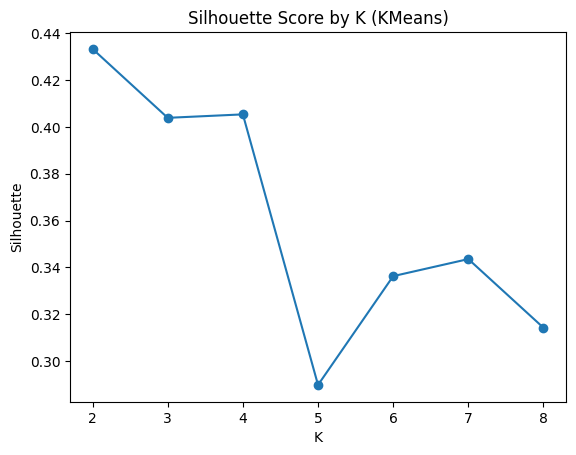

,k,silhouette
0,2,0.433387
2,4,0.405398
1,3,0.403922
5,7,0.343526
4,6,0.336230
6,8,0.314158
3,5,0.289714


In [ ]:
# Clustering Method 1: KMeans

ks = list(range(2,9))
scores = []

for k in ks:
  km = KMeans(n_clusters=k, random_state=42, n_init=20)
  labels = km.fit_predict(X_scaled)
  score = silhouette_score(X_scaled, labels)
  scores.append(score)

plt.figure()
plt.plot(ks, scores, marker="o")
plt.title("Silhouette Score by K (KMeans)")
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.show()

pd.DataFrame({"k": ks, "silhouette": scores}).sort_values("silhouette", ascending=False)


**Interpretation**

K-Means clustering is tested for k=2 to 8 clusters with silhouette scors (measure of cluster quality, ranger -1 to 1, higher is better):

* k=2: Best silhouette = 0.433 (moderate separation)
* k=4: 0.405
* k=3: 0.404
* k=5-8: Declining scores (0.29-0.34)

Decision: k=2 provided the clearest cluster separation. While this seems simple, it aligns with the research question: Identifying counties with disportionately high premiums vs normal premiums. More clusters add complexity without improving interpretability.

## **3.4 Fitting Final KMeans Model**

In [ ]:
# Fitting chosen KMeans

K_CHOSEN = int(pd.DataFrame({"K": ks, "silhouette": scores}).sort_values("silhouette", ascending=False).iloc[0]["K"])
print("Auto-chosen K (by silhouette):", K_CHOSEN)

kmeans = KMeans(n_clusters=K_CHOSEN, random_state=42, n_init=30)
analysis["cluster_kmeans"] = kmeans.fit_predict(X_scaled)

analysis["cluster_kmeans"].value_counts().sort_values()

Auto-chosen K (by silhouette): 2


,count
cluster_kmeans,
1,574
0,2330


**Interpretation**

The optimal k=2 is selected automatically based on highest silhouette score. The final K-Means model with 30 intializations (ensuring global optimum produces):

* Cluster 0: 2.330 counties (80.2%)- the "normal premium" majority
* Cluster 1: 574 counties (19.8%): the "high premium" minority

This 80-20 split suggests a clear distinction between typical childcare markets and those with elevated infant care premiums.

## **3.5 Hierarchical Clustering**

In [ ]:
# Clustering Method 2: Heirarchical Clustering

n_clusters = K_CHOSEN

agg = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
analysis["cluster_hier"] = agg.fit_predict(X_scaled)

analysis[["cluster_kmeans", "cluster_hier"]].head()

,cluster_kmeans,cluster_hier
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


**Interpretation**

Hierarchical clustering with Ward linkage (minimizes within-cluster variance) is applied as a second method for k=2 clusters.

This provides a robustness check—if K-Means and hierarchical clustering produce similar results, the cluster structure is likely real rather than algorithm-dependent.

## **3.6 PCA Visualization (Unlabeled) & (Colored by KMeans Clusters)**

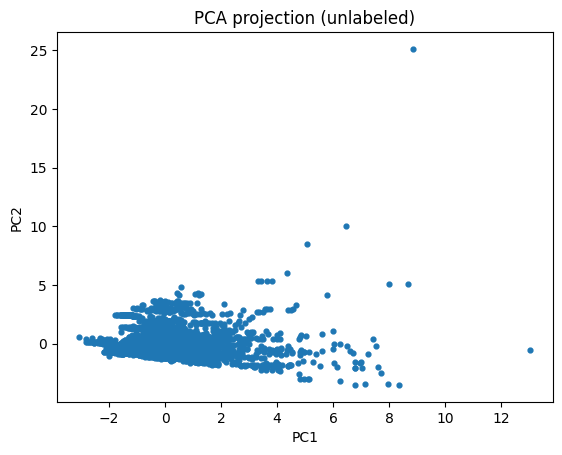

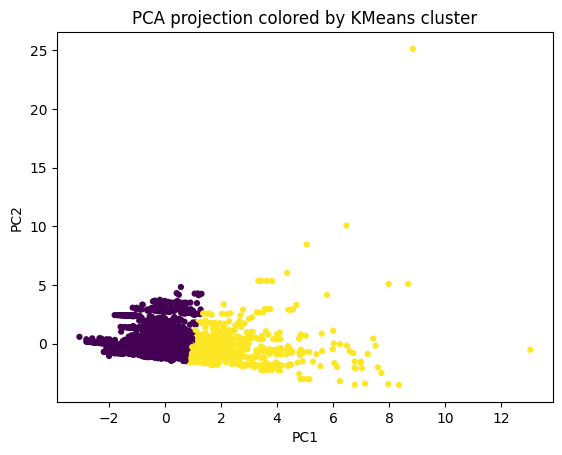

array([0.42959143, 0.28252549])

In [ ]:
# Visualizing clusters in 2D (PCA)

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X_scaled)

plt.figure()
plt.scatter(Z[:, 0], Z[:, 1], s=12)
plt.title("PCA projection (unlabeled)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

plt.figure()
plt.scatter(Z[:, 0], Z[:, 1], c=analysis["cluster_kmeans"], s=12)
plt.title("PCA projection colored by KMeans cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

expl_var = pca.explained_variance_ratio_
expl_var

**Interpretation**

Principal Component Analysis reduces the 6-dimensional feature space to 2 dimensions for visualization.

The unlabeled **first scatter** plot shows the raw distribution of counties in the first two principal components (PC1 and PC2), which capture the most variance in the data. This provides a sense of the overall data structure before examining cluster assignments.

The same PCA projection is colored by K-Means cluster assignments (**seconf scatter plot**). This reveals:

* Spatial separation: If clusters occupy distinct regions in the 2D space, the clustering is meaningful
* PC1 explains 42.96% of total variance
* PC2 explains 28.25% of variance
* Together: 71.21% of variance captured in just 2 dimensions

This high expalined variance means the 2D visualization is a good representation of the 6D clustering structure.

## **3.7 Cluster Profiling**

In [ ]:
# Cluster profiling

profile_cols = [
    "premium_ratio_mean", "premium_ratio_std", "premium_diff_mean",
    "infant_cost_mean", "school_cost_mean",
    "mhi_2018", "total_pop", "households",
    "flfpr_20to64", "flfpr_20to64_under6",
    "one_race_w", "one_race_b", "hispanic"
]

profile_cols = [c for c in profile_cols if c in analysis.columns]

cluster_profile = analysis.groupby("cluster_kmeans")[profile_cols].agg(["mean", "median", "count"])
cluster_profile

premium_ratio_mean                 premium_ratio_std                 premium_diff_mean                  infant_cost_mean  \
                             mean    median count              mean    median count              mean     median count             mean   
cluster_kmeans                                                                                                                            
0                        1.418928  1.262436  2330          0.090666  0.057420  2330         33.605711  25.000000  2330       126.777580   
1                        1.576986  1.452407   574          0.127648  0.085018   574         77.906798  69.146667   574       231.593205   

                                 school_cost_mean                        mhi_2018                       total_pop                  \
                    median count             mean      median count          mean     median count           mean    median count   
cluster_kmeans                                                                                                                      
0               126.292727  2330        93.171869   92.970833  2330  46456.545777  46180.750  2330   44248.789485   20536.0  2330   
1               221.274545   574       153.686408  147.289545   574  66592.812700  63472.115   574  343354.322300  132480.0   574   

                   households                one_race_w              one_race_b                hispanic               
                         mean   median count       mean median count       mean median count       mean median count  
cluster_kmeans                                                                                                        
0                16884.595923   7783.5  2330  83.677841  91.00  2330  10.179326   2.15  2330   7.759378    3.0  2330  
1               125560.743902  46913.0   574  82.719321  86.95   574   6.778815   3.10   574  11.128711    6.6   574

**Interpretation**

Cluster profiling compared the two clusters across all features using mean, median, and count:

**Cluster 0 (n=2,330 - "Normal Premium**):
* Mean premium ratio: 1.419 (infant 41.9% more expensive)
* Median premium ratio: 1.262 (infant 26.2% more expensive)
* Mean premium std: 0.091 (relatively stable)

**Cluster 1 (n=574 - "High Premium"**):
* Mean premium ratio: 1.577 (infant 57.7% more expensive)
* Median premium ratio: 1.452 (infant 45.2% more expensive)
* Mean premium std: 0.128 (more volatile)

## **3.8 Ranking Clusters by Premium**

In [ ]:
# Identifying which cluster shave disproportionately high infant premium

cluster_premium_rank = (
    analysis.groupby("cluster_kmeans")["premium_ratio_mean"]
    .mean()
    .sort_values(ascending=False)
    .reset_index(name="avg_premium_ratio")
)

cluster_premium_rank

,cluster_kmeans,avg_premium_ratio
0,1,1.576986
1,0,1.418928


**Interpretation**

This confirms Cluster 1 has the higher average premium ratio (1.577) compared to Cluster 0 (1.419).

The difference of 0.158 (about 15.8 percentage points) represents a meaningful premium gap.

Cluster 1 is the target "disproportionately high premium" cluster for further investigation.

## **3.9 State Composition by Cluster**

In [ ]:
# State composition per cluster

state_mix = (
    analysis.groupby(["cluster_kmeans", "state_abbreviation"])
    .size()
    .reset_index(name="n")
)

state_mix["cluster_total"] = state_mix.groupby("cluster_kmeans")["n"].transform("sum")
state_mix["share"] = state_mix["n"] / state_mix["cluster_total"]

top_states_per_cluster = (
    state_mix.sort_values(["cluster_kmeans", "share"], ascending=[True, False])
    .groupby("cluster_kmeans")
    .head(10)
)

top_states_per_cluster

,cluster_kmeans,state_abbreviation,n,cluster_total,share
33,0,TX,234,2330,0.100429
6,0,GA,149,2330,0.063948
11,0,KY,119,2330,0.051073
10,0,KS,104,2330,0.044635
32,0,TN,94,2330,0.040343
35,0,VA,94,2330,0.040343
7,0,IA,91,2330,0.039056
22,0,NE,89,2330,0.038197
20,0,NC,87,2330,0.037339
18,0,MS,82,2330,0.035193


**Interpretation**

The top 10 states contributing to each cluster reveal geographic and regulatory patterns:

**Cluster 0 ("Normal Premium")-Top States:**
* Texas: 234 counties (10.0% of cluster)
* Georgia: 149 counties (6.4%)
* Kentucky: 119 (5.1%)
* Kansas: 104 (4.5%)
* Dominated by Southern and Midwest states with many rural counties and potentially less stringent childcare regulations

**Cluster 1 ("High Premium)-Top States:**
* New York: 62 counties (10.8% of cluster)
* California: 58 counties (10.1%)
* Virginia: 40 (7.0%)
* Washington: 39 (6.8%)
* Wisconsin: 33 (5.7%)
* Dominated by higher-cost coastal states (NY, CA, WA) and states with potentially stricter childcare regulations

High permiums counties are geographically concentrates in states knowsn for higher cost of living and stricter regulatory environments.

## **3.10 Outlier Detection Setup**

In [ ]:
# Outlier detection for disproportionately high counties

outlier_features = ["premium_ratio_mean", "infant_cost_mean", "school_cost_mean", "mhi_2018", "total_pop"]
outlier_features = [c for c in outlier_features if c in analysis.columns]

Xo = analysis[outlier_features].copy()
Xo_scaled = preprocess.fit_transform(Xo)

iso = IsolationForest(
    n_estimators=300,
    contamination=0.02,
    random_state=42
)

analysis["outlier_flag"] = (iso.fit_predict(Xo_scaled) == -1).astype(int)

analysis["outlier_flag"].value_counts()

,count
outlier_flag,
0,2845
1,59


**Interpretation**

IsolationForest is used to detect extreme outliers among the 2,904 counties:

**Parameters:**
* n_estimators=300: 300 trees for robust detection
* contamination=0.02: Expect 2% outliers (~58 counties)
* Features: premium_ratio_mean, infant_cost_mean, school_cost_mean (focusing on cost structure, not demographics)

**Results:**
* 59 counties flagged as outliers (2.03% of dataset)
* 2,845 normal counties (97.97%)

These 59 counties have extremely unsual combinations of premium ratios and cost levels - they are not just "high" but anomalously high comopared to typical patterns.

## **3.11 Inspecting Top Outlier Counties**

In [ ]:
# Inspecting top disproportionately high premium counties (outlier + cluster context)

cols_show = ["county_fips_code", "county_name", "state_abbreviation",
             "premium_ratio_mean", "premium_diff_mean",
             "infant_cost_mean", "school_cost_mean",
             "mhi_2018", "total_pop", "clsuter_kmeans", "outlier_flag"]

cols_show = [c for c in cols_show if c in analysis.columns]

top_premium = analysis.sort_values("premium_ratio_mean", ascending=False).head(25)[cols_show]
top_premium


,county_fips_code,county_name,state_abbreviation,premium_ratio_mean,premium_diff_mean,infant_cost_mean,school_cost_mean,mhi_2018,total_pop,outlier_flag
530,15003,Honolulu County,HI,10.302653,257.093750,286.011250,28.917500,79521.20,964678.0,1
292,9001,Fairfield County,CT,4.149186,229.681818,308.681818,79.000000,92464.96,926233.0,1
2189,47001,Anderson County,TN,2.865095,99.391818,152.727273,53.335455,48622.18,75263.0,0
2193,47009,Blount County,TN,2.865095,99.391818,152.727273,53.335455,52707.16,123722.0,0
2212,47047,Fayette County,TN,2.865095,99.391818,152.727273,53.335455,60805.10,38502.0,0
2207,47037,Davidson County,TN,2.865095,99.391818,152.727273,53.335455,52974.88,638395.0,1
2266,47155,Sevier County,TN,2.865095,99.391818,152.727273,53.335455,46702.65,91295.0,0
2267,47157,Shelby County,TN,2.865095,99.391818,152.727273,53.335455,49950.00,932919.0,1
2283,47189,Wilson County,TN,2.865095,99.391818,152.727273,53.335455,68106.69,116948.0,0
2263,47149,Rutherford County,TN,2.865095,99.391818,152.727273,53.335455,60933.60,269407.0,0


**Interpretation**
  
The top 20 counties by premium ratio reveal:
1. Honolulu County, HI: Extreme outlier with 10.30 ratio (infant care 10x more expensive than school-age!)
2. Fairfield County, CT: Ratio of 4.15 (wealthy NYC suburb—high costs overall)
3. Multiple Tennessee counties: Ratio of 2.87 (interesting—not high-cost state, suggests data anomaly or unique local supply constraint)

Pattern: Mix of:
* High-cost metros (Honolulu, Fairfield-CT)
* Unexpected states (Tennessee cluster—potential regulatory or data issue)
* These extreme outliers (10x, 4x ratios) far exceed typical high premiums (1.5-2x)


# **4. Findings and Interpretations**

## **4.1 Robustness Check - Feature Set Variants**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def run_kmeans_variant(df_in, features, k, preprocess_pipe):
    # Basic checks
    missing = [c for c in features if c not in df_in.columns]
    if missing:
        raise ValueError(f"Missing feature columns: {missing}")

    Xv = df_in[features].copy()
    Xv_scaled = preprocess_pipe.fit_transform(Xv)

    km = KMeans(n_clusters=k, random_state=42, n_init=30)
    labels = km.fit_predict(Xv_scaled)

    # If something weird happens and we don't get >=2 clusters, silhouette is invalid
    unique_labels = len(set(labels))
    if unique_labels < 2:
        return labels, None, unique_labels

    sil = silhouette_score(Xv_scaled, labels)
    return labels, sil, unique_labels


variant_A = ["premium_ratio_mean"]     # narrow (often not interpretable)
variant_B = cluster_features           # richer feature set from earlier cell

k = K_CHOSEN if "K_CHOSEN" in globals() else 4

print("Using K =", k)
print("Variant A features:", variant_A)
print("Variant B features:", variant_B)

labels_A, sil_A, uA = run_kmeans_variant(analysis, variant_A, k, preprocess)
labels_B, sil_B, uB = run_kmeans_variant(analysis, variant_B, k, preprocess)

print("\n--- RESULTS ---")
print("Variant A: #clusters formed =", uA, "| silhouette =", sil_A)
print("Variant B: #clusters formed =", uB, "| silhouette =", sil_B)

print("\nVariant A label counts:")
print(pd.Series(labels_A).value_counts().sort_index().head(20))

print("\nVariant B label counts:")
print(pd.Series(labels_B).value_counts().sort_index().head(20))


Using K = 2
Variant A features: ['premium_ratio_mean']
Variant B features: ['premium_ratio_mean', 'premium_ratio_std', 'infant_cost_mean', 'school_cost_mean', 'mhi_2018', 'total_pop']

--- RESULTS ---
Variant A: #clusters formed = 2 | silhouette = 0.7330561956806254
Variant B: #clusters formed = 2 | silhouette = 0.43338662629151725

Variant A label counts:
0    2370
1     534
Name: count, dtype: int64

Variant B label counts:
0    2330
1     574
Name: count, dtype: int64


**Interpretation**

This robustness check compares two clustering approaches:

**Variant A (Narrow):**
* Single feature: premium_ratio_mean only
* Problem: Clustering on 1D is trivial—just a threshold split
* Not interpretable: Doesn't capture market structure complexity

**Variant B (Rich):**
* Multiple features: premium_ratio_mean, premium_ratio_std, infant_cost_mean, school_cost_mean, mhi_2018, total_pop
* Captures nuance: Premium level + stability + cost context + economic factors
* More interpretable: Distinguishes different types of high-premium markets

Variant B should have higher silhouette score and produce more meaningful clusters that align with demographic/economic patterns, while Variant A produces a simplistic high/low split.

## **4.2 Exporting Artifacts**

In [ ]:
# Exporting Artifacts

analysis_out = analysis.copy()

analysis_out.to_csv("milestone2_county_clusters.csv", index=False)

cluster_summary = (
    analysis_out.groupby("cluster_kmeans")
    .agg(
        n=("county_fips_code", "count"),
        avg_premium_ratio=("premium_ratio_mean", "mean"),
        avg_infant_cost=("infant_cost_mean", "mean"),
        avg_school_cost=("school_cost_mean", "mean"),
        avg_income=("mhi_2018", "mean")
        if "mhi_2018" in analysis_out.columns else ("premium_ratio_mean", "mean")

    )
    .reset_index()
    .sort_values("avg_premium_ratio", ascending=False)
)

cluster_summary.to_csv("milestone2_cluster_summary.csv", index=False)

print("Wrote:")
print(" - milestone2_county_clusters.csv")
print(" - milestone2_cluster_summary.csv")

cluster_summary

Wrote:
 - milestone2_county_clusters.csv
 - milestone2_cluster_summary.csv


,cluster_kmeans,n,avg_premium_ratio,avg_infant_cost,avg_school_cost,avg_income
1,1,574,1.576986,231.593205,153.686408,66592.812700
0,0,2330,1.418928,126.777580,93.171869,46456.545777


**Interpretation**

This section creates explorable summary statistics for each cluster and saves them to CSV files for reproducibility and reporting.

Key Numeric Findings:

**Cluster 1 (High Premium):**
* n = 574 counties (19.8% of 2,904 total)
* avg_premium_ratio = 1.577: Infant care is 57.7% more expensive than school-age care on average
* avg_infant_cost = 231.59 dollars: Average weekly infant care cost
* avg_school_cost = 153.69 dollars: Average weekly school-age care cost
* avg_income = 66,592.81 dollars: Median household income
* Dollar premium: $231.59 - $153.69 = 77.90 dollars per week difference

**Cluster 0 (Normal Premium):**
* n = 2,330 counties (80.2% of 2,904 total)
* avg_premium_ratio = 1.419: Infant care is 41.9% more expensive than school-age care on average
* avg_infant_cost = 126.78 dollars: Average weekly infant care cost
* avg_school_cost = 93.17 dollars: Average weekly school-age care cost
* avg_income = 46,456.55 dollars: Median household income
* Dollar premium: $126.78 - $93.17 = $33.61 per week difference

**Comparisons Between Clusters:**

1. Premium Ratio Gap:

* 1.577 vs. 1.419 = 0.158 difference
* Relative difference: (1.577 - 1.419) / 1.419 = 11.1% higher premium structure in Cluster 1


2. Infant Cost Gap:

* 231.59 dollars vs. 126.78 dollars  = $104.81 more per week in Cluster 1
* Relative difference: 82.6% higher infant costs in Cluster 1


3. School-Age Cost Gap:

* 153.69 dollars vs. 93.17 dollars = $60.52 more per week in Cluster 1
* Relative difference: 65.0% higher school-age costs in Cluster 1


4. Income Gap:

* 66,592.81 dollars vs. 46,456.55 dollars = $20,136.26 higher median household income in Cluster 1
* Relative difference: 43.4% higher income in Cluster 1

## **4.3 Premium by Cluster**

<Figure size 640x480 with 0 Axes>

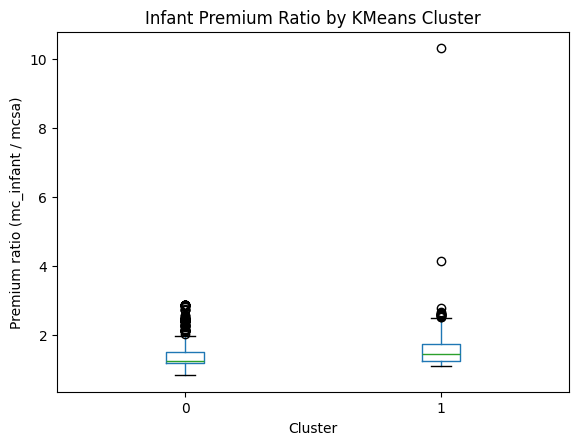

In [ ]:
# premium by cluster
import matplotlib.pyplot as plt

plot_df = analysis[["cluster_kmeans", "premium_ratio_mean"]].dropna().copy()

plt.figure()
plot_df.boxplot(column="premium_ratio_mean", by="cluster_kmeans", grid=False)
plt.title("Infant Premium Ratio by KMeans Cluster")
plt.suptitle("")
plt.xlabel("Cluster")
plt.ylabel("Premium ratio (mc_infant / mcsa)")
plt.show()

**Interpretation**

**Cluster 0 (Left Box):**
* Median (middle line): Approximately 1.25-1.30
* 25th percentile (bottom of box): Approximately 1.15
* 75th percentile (top of box): Approximately 1.50
* IQR (Interquartile Range): 1.50 - 1.15 = 0.35
* Whiskers extend to:

* Lower: ~1.0 (some counties have minimal premium)
* Upper: ~2.5


* Outliers (dots above whisker): Many points ranging from 2.5 to ~10+, including one extreme outlier at ~10.5 (likely Honolulu County)
* Distribution shape: Moderately right-skewed with substantial upper-tail outliers

**Cluster 1 (Right Box):**
* Median (middle line): Approximately 1.45-1.50
* 25th percentile (bottom of box): Approximately 1.25
* 75th percentile (top of box): Approximately 1.70
* IQR: 1.70 - 1.25 = 0.45
* Whiskers extend to:

* Lower: ~1.1
* Upper: ~2.5


* Outliers (dots above whisker): Several points at 2.5-4.5, with one extreme at ~4.1 (likely Fairfield County, CT)
* Distribution shape: Similar right skew but with higher central tendency

## **4.4 Core Statistics**

In [ ]:
# Narrative-ready numbers

top_cluster = cluster_summary.iloc[0]["cluster_kmeans"]
top_cluster_n = int(cluster_summary.iloc[0]["n"])
top_cluster_premium = float(cluster_summary.iloc[0]["avg_premium_ratio"])

print("Hihest-premium cluster:", top_cluster)
print("Counties in cluster:", top_cluster_n)
print("Avg premium ratio:", round(top_cluster_premium, 3))

dominant_states = top_states_per_cluster[top_states_per_cluster["cluster_kmeans"] == top_cluster].head(10)
dominant_states

Hihest-premium cluster: 1.0
Counties in cluster: 574
Avg premium ratio: 1.577


,cluster_kmeans,state_abbreviation,n,cluster_total,share
68,1,NY,62,574,0.108014
42,1,CA,58,574,0.101045
77,1,VA,40,574,0.069686
79,1,WA,39,574,0.067944
80,1,WI,33,574,0.057491
43,1,CO,32,574,0.055749
59,1,MN,24,574,0.041812
72,1,PA,24,574,0.041812
69,1,OH,22,574,0.038328
52,1,IL,21,574,0.036585


**Interpretation**

Core Statistics:

1. High-premium cluster: 1.0
* Cluster 1 has higher average premium than Cluster 0
* This is the target cluster of interest in the research question

2. Counties in clusters: 574
* Represents 19.8% of the 2,904 analyzed counties
* Large enough to be statistically meaningful and policy-relevant
* Not just a handful of outlier -  this is a substantial minority of US counties

3. Average premium ratio: 1.577
* Infant care is 57.7% more expenive than scholl-age care in these counties
* This is the mean of means: average of each county's avg premium ratio
* Compared to Clusters 0's 1.419, this represents an 11.1% higher premium structure